# Problem Set 1: Analysis of racial disparities in felony sentencing

# 0. Load packages and imports

In [1]:
## basic functionality
import pandas as pd
import numpy as np
import re

## can add others if you need them

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 0.1: Load the data (0 points)

Load the `sentencing_asof0405.csv` data

*Notes*: You may receive a warning about mixed data types upon import; feel free to ignore

In [77]:
df = pd.read_csv('sentencing_asof0405.csv')

/var/folders/c_/y_pwd2zx5ps_3xsk7x2275gw0000gp/T/ipykernel_9774/977872858.py:1: DtypeWarning: Columns (10,11,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('sentencing_asof0405.csv')


## 0.2: Print head, dimensions, info (0 points)

In [361]:
print(df.head())
print(df.ndim)
print(df.shape)
print(df.info)

        CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0  149765331439         175691153649  8/15/1984 12:00:00 AM   
1  149765331439         175691153649  8/15/1984 12:00:00 AM   
2  149765331439         175691153649  8/15/1984 12:00:00 AM   
3  149765331439         175691153649  8/15/1984 12:00:00 AM   
4  149765331439         175691153649  8/15/1984 12:00:00 AM   

    OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG    CHARGE_ID  CHARGE_VERSION_ID  \
0  PROMIS Conversion                False  50510112469       116304211997   
1  PROMIS Conversion                False  50510213021        98265074680   
2  PROMIS Conversion                False  50516447217       131972895911   
3  PROMIS Conversion                False  50516497493       131966356472   
4  PROMIS Conversion                False  50516648320        98059642859   

  DISPOSITION_CHARGED_OFFENSE_TITLE  CHARGE_COUNT        DISPOSITION_DATE  \
0               FIRST DEGREE MURDER             2  12/17/2014 12:00:00 AM   
1   

# Part one: data cleaning/interpretation

## 1.1: Understanding the unit of analysis (5 points)

- Print the number of unique values for the following columns. Do so in a way that avoids copying/pasting code for 
the three:

    - Cases (`CASE_ID`)
    - People in that case (`CASE_PARTICIPANT_ID`)
    - Charges (`CHARGE_ID`)

- Write a couple sentences on the following and show an example of each (e.g., a case involving multiple people):
    
    - Why there are more unique people than unique cases?
    - Why there are more unique charges than unique people?

- Print the mean and median number of charges per case/participant 

- Print the mean and median number of participants per case

- Does the data seem to enable us to follow the same defendant across different cases they're charged in? Write 1 sentence in support of your conclusion.


In [362]:
unique_val_cols = ["CASE_ID", "CASE_PARTICIPANT_ID", "CHARGE_ID"]

# loop through specified columns and find # of unique values in each
for col in unique_val_cols:
    unique_values = df[col].nunique()
    print("# of unique values for column " + col + ": " + str(unique_values))

# of unique values for column CASE_ID: 197519
# of unique values for column CASE_PARTICIPANT_ID: 211977
# of unique values for column CHARGE_ID: 229015


There are more unique people than unique cases because multiple people can be charged in the same case. For example, if two people commit a burglary together, both of them will be in charged, and that's already more unique people than cases. Multiple cases may have that same situation, and that's how there are more unique people than cases.   

There are more unique charges than unique people because one person can be levied with multiple charges - "charge stacking". For example, if someone is committing financial crimes at their work, they could be charged with a number of related charges like embezzlement, extortion, fraud, etc. Since many charges can be assigned to one person, there are more unique charges than people. 

In [363]:
# get number of charges per defendant
participant_charges = df.groupby('CASE_PARTICIPANT_ID')['CHARGE_ID'].nunique()
mean_participant_charges = participant_charges.mean()
median_participant_charges = participant_charges.median()
print("mean number of charges per participant: " + str(mean_participant_charges))
print("median number of charges per participant: " + str(median_participant_charges))

# get number of charges per case
case_charges = df.groupby('CASE_ID')['CHARGE_ID'].nunique()
mean_case_charges = case_charges.mean()
median_case_charges = case_charges.median()
print("mean number of charges per case: " + str(mean_case_charges))
print("median number of charges per case: " + str(median_case_charges))

# get number of defendants per case
participants_per_case = df.groupby('CASE_ID')['CASE_PARTICIPANT_ID'].nunique()
mean_ppc = participants_per_case.mean()
median_ppc = participants_per_case.median()
print("mean number of participants per case: " + str(mean_ppc))
print("median number of participants per case: " + str(median_ppc))

mean number of charges per participant: 1.1261457610967227
median number of charges per participant: 1.0
mean number of charges per case: 1.1594580774507768
median number of charges per case: 1.0
mean number of participants per case: 1.0731980214561636
median number of participants per case: 1.0


Yes, the data does seem to enable us to follow the same defendant across the different cases they're charged in. 
In this data set, there are more cases than participants which indicates that this data set allows you to track individual defendants across all the cases they're charged in. If the inverse was true (more participants than cases), it would be indicative that this data set is placing a greater emphasis on tracking cases. 

## 1.2.1: Which offense is final? (3 points)

- First, read the data documentation [link](https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf) and summarize in your own words the differences between `OFFENSE_CATEGORY` and `UPDATED_OFFENSE_CATEGORY` 

- Construct an indicator `is_changed_offense` that's True for case-participant-charge observations (rows) where there's a difference between the original charge (offense category) and the most current charge (updated offense category). What are some of the more common changed offenses? (can just print result of sort_values based on original offense category)

- Print one example of a changed offense from one of these categories and comment on what the reason may be


`OFFENSE_CATEGORY`refers to the broad offenses before a specific charge has been filed on a case, whereas `UPDATED_OFFENSE_CATEGORY` is the updated category of the case that is based on the primary charge against the defendent. Basically, `UPDATED_OFFENSE_CATEGORY` accounts for how the focus of the case may evolve as the investigation  develops. Additionally, while there are five data sets for `OFFENSE_CATEGORY`
(intake, initiation, disposition, sentencing, and diversion), there are only four data sets for `UPDATED_OFFENSE_CATEGORY`(intake, initiation
disposition, and sentencing).

In [364]:
# indicator marked if offense category is different from updated category
df["is_changed_offense"] = df["OFFENSE_CATEGORY"] != df["UPDATED_OFFENSE_CATEGORY"]
changed_offenses = df[df["is_changed_offense"]]["OFFENSE_CATEGORY"].value_counts()
# sort by most to least number of categories that change
changed_offenses_sort = changed_offenses.sort_values(ascending=False)

# show top 10 most common changed offenses
print(changed_offenses_sort.head(10))

OFFENSE_CATEGORY
PROMIS Conversion               6394
DUI                             3896
UUW - Unlawful Use of Weapon    2155
Other Offense                   2125
Aggravated Battery              1927
Burglary                        1513
Attempt Homicide                1174
Theft                           1025
Domestic Battery                 793
Aggravated DUI                   748
Name: count, dtype: int64


In [365]:
# get DUI category
cat = changed_offenses_sort.index[1]
# find example of a DUI charge that got changed
example_change = df[df['OFFENSE_CATEGORY'] == cat].iloc[0]

print("OFFENSE_CATEGORY value: " + example_change['OFFENSE_CATEGORY'])
print("UPDATED_OFFENSE_CATEGORY value: " + example_change['UPDATED_OFFENSE_CATEGORY'])

OFFENSE_CATEGORY value: DUI
UPDATED_OFFENSE_CATEGORY value: Aggravated DUI
In this case, the offense was likely updated from DUI to Aggravated DUI because investigation showed that the drunk driver was speeding or driving more recklessly. To account for the increased severity of the crime, the offense category was updated.


In this case, the offense was likely updated from DUI to Aggravated DUI because investigation showed that the drunk driver was speeding or driving more recklessly. To account for the increased severity of the crime, the offense category was updated. The offense may also change due to how a defendant pleads, new evidence that arises during a case, or a plea bargain that is come to after the initial charging. 

## 1.2.2: Simplifying the charges (5 points)

Using the field (`UPDATED_OFFENSE_CATEGORY`), create a new field, `simplified_offense_derived`, that simplifies the many offense categories into broader buckets using the following process:

First, combine all offenses beginning with "Aggravated" into a single category without that prefix (e.g., Aggravated Battery and Battery just becomes Battery)

Then:
- Combine all offenses with arson into a single arson category (`Arson`)
- Combine all offenses with homicide into a single homicide category (`Homicide`)
- Combine all offenses with vehicle/vehicular in the name into a single vehicle category (`Vehicle-related`)
- Combine all offenses with battery in the name into a single battery category (`Battery`)

Try to do so efficiently (e.g., using map and a dictionary or np.select rather than separate line for each recoded offense)

Print the difference between the # of unique offenses in the original `UPDATED_OFFENSE_CATEGORY` field and the # of unique offenses in your new `simplified_offense_derived` field


In [366]:
# get rid of aggravated prefix
df["updated_offense_cat"] = df.UPDATED_OFFENSE_CATEGORY.str.replace("Aggravated", "")

# new categories
cats = ["Arson", "Homicide", "Vehicle-related", "Battery"]
conditions = [
    df.UPDATED_OFFENSE_CATEGORY.str.contains("Arson"),
    df.UPDATED_OFFENSE_CATEGORY.str.contains("Homicide"),
    df.UPDATED_OFFENSE_CATEGORY.isin(["Vehicle", "Vehicular"]),
    df.UPDATED_OFFENSE_CATEGORY.str.contains("Battery")
]

# keep default  as original value if none of the conditions are met
df['simplified_offense_derived'] = np.select(conditions, cats, default=df['UPDATED_OFFENSE_CATEGORY'])
df

# compare number of unique offenses
orig_unique_offenses = df["UPDATED_OFFENSE_CATEGORY"].nunique()
print("original number of unique offenses: " + str(orig_unique_offenses))
new_unique_offenses = df["simplified_offense_derived"].nunique()
print("new number of unique offenses: " + str(new_unique_offenses))
print("difference is: " + str(orig_unique_offenses - new_unique_offenses))

CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0       149765331439         175691153649  8/15/1984 12:00:00 AM   
1       149765331439         175691153649  8/15/1984 12:00:00 AM   
2       149765331439         175691153649  8/15/1984 12:00:00 AM   
3       149765331439         175691153649  8/15/1984 12:00:00 AM   
4       149765331439         175691153649  8/15/1984 12:00:00 AM   
...              ...                  ...                    ...   
248141  445516248775         905289187184   2/3/2021 12:00:00 AM   
248142  445527409730         905322500577   2/4/2021 12:00:00 AM   
248143  445587767000         905518794790   2/9/2021 12:00:00 AM   
248144  445592613204         905533705601   2/9/2021 12:00:00 AM   
248145  445593200623         905535215556   2/9/2021 12:00:00 AM   

                                 OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG  \
0                               PROMIS Conversion                False   
1                               PROMIS Conversion                False   
2                               PROMIS Conversion                False   
3                               PROMIS Conversion                False   
4                               PROMIS Conversion                False   
...                                           ...                  ...   
248141                              Home Invasion                 True   
248142                           Domestic Battery                 True   
248143  Driving With Suspended Or Revoked License                 True   
248144  Driving With Suspended Or Revoked License                 True   
248145  Driving With Suspended Or Revoked License                 True   

           CHARGE_ID  CHARGE_VERSION_ID  DISPOSITION_CHARGED_OFFENSE_TITLE  \
0        50510112469       116304211997                FIRST DEGREE MURDER   
1        50510213021        98265074680                      HOME INVASION   
2        50516447217       131972895911                FIRST DEGREE MURDER   
3        50516497493       131966356472                FIRST DEGREE MURDER   
4        50516648320        98059642859                      HOME INVASION   
...              ...                ...                                ...   
248141  447867029248       836341344232  AGGRAVATED UNLAWFUL USE OF WEAPON   
248142  447970697900       836537247156                   DOMESTIC BATTERY   
248143  447955866546       837760215766       DRIVING ON SUSPENDED LICENSE   
248144  447966223356       837758347354       DRIVING ON SUSPENDED LICENSE   
248145  447966323908       837759561822       DRIVING ON SUSPENDED LICENSE   

        CHARGE_COUNT        DISPOSITION_DATE  ... age_derived  \
0                  2  12/17/2014 12:00:00 AM  ...        27.0   
1                 14  12/17/2014 12:00:00 AM  ...        27.0   
2                  4  12/17/2014 12:00:00 AM  ...        27.0   
3                  5  12/17/2014 12:00:00 AM  ...        27.0   
4                 13  12/17/2014 12:00:00 AM  ...        27.0   
...              ...                     ...  ...         ...   
248141             1   3/19/2021 12:00:00 AM  ...        19.0   
248142             1   3/23/2021 12:00:00 AM  ...        32.0   
248143             1   3/11/2021 12:00:00 AM  ...        29.0   
248144             1   3/11/2021 12:00:00 AM  ...        29.0   
248145             1   3/21/2021 12:00:00 AM  ...        30.0   

             SENTENCE_DATE_STR SENTENCE_DATE_DT sentenceymd_derived  \
0         6/2/1986 12:00:00 AM       1986-06-02          1986-06-02   
1         6/2/1986 12:00:00 AM       1986-06-02          1986-06-02   
2         6/2/1986 12:00:00 AM       1986-06-02          1986-06-02   
3         6/2/1986 12:00:00 AM       1986-06-02          1986-06-02   
4       10/16/2014 12:00:00 AM       2014-10-16          2014-10-16   
...                        ...              ...                 ...   
248141   3/19/2021 12:00:00 AM       2021-03-19          2021-03-19   
248142   3/23/2021 12

original number of unique offenses: 79
new number of unique offenses: 71
difference is: 8


## 1.3: Cleaning additional variables (10 points)

Clean the following variables; make sure to retain the original variable in data and use the derived suffix so it's easier to pull these cleaned out variables later (e.g., `age_derived`) to indicate this was a transformation

- Race: create True/false indicators for `is_black_derived` (Black only or mixed race with hispanic), Non-Black Hispanic, so either hispanic alone or white hispanic (`is_hisp_derived`), White non-hispanic (`is_white_derived`), or none of the above (`is_othereth_derived`)

- Gender: create a boolean true/false indicator for `is_male_derived` (false is female, unknown, or other)

- Age at incident: you notice outliers like 130-year olds. Winsorsize the top 0.01% of values to be equal to the 99.99th percentile value pre-winsorization. Call this `age_derived`

- Create `sentenceymd_derived` that's a version of `SENTENCING_DATE` converted to datetime format. Also create a rounded version, `sentenceym_derived`, that's rounded down to the first of the month and the year (e.g., 01-05-2016 and 01-27-2016 each become 01-01-2016)
    - Hint: all timestamps are midnight so u can strip in conversion. For full credit, before converting, you notice that some of the years have been mistranscribed (e.g., 291X or 221X instead of 201X). Programatically fix those (eg 2914 -> 2014). Even after cleaning, there will still be some that are after the year 2021 that we'll filter out later. For partial credit, you can ignore the timestamps that cause errors and set errors = "coerce" within `pd.to_datetime()` to allow the conversion to proceed. 

- Sentencing judge: create an identifier (`judgeid_derived`) for each unique judge (`SENTENCE_JUDGE`) structured as judge_1, judge_2...., with the order determined by sorting the judges (will sort on fname then last). When finding unique judges, there are various duplicates we could weed out --- for now, just focus on (1) the different iterations of Doug/Douglas Simpson, (2) the different iterations of Shelley Sutker (who appears both with her maiden name and her hyphenated married name). 
     - Hint: due to mixed types, you may need to cast the `SENTENCE_JUDGE` var to a diff type to sort

After finishing, print a random sample of 10 rows (data.sample(n = 10)) with the original and cleaned columns for the relevant variables to validate your work

In [374]:
# cleaned race columns
df["is_black_derived"] = df.RACE.str.upper().str.contains("BLACK", na=False)
df["is_hisp_derived"] = df.RACE.str.upper().str.contains("HISPANIC", na=False)
df["is_white_derived"] = df.RACE.str.upper().str.contains("WHITE", na=False) & ~df["is_hisp_derived"]
df["is_othereth_derived"] = ~df["is_hisp_derived"] & ~df["is_black_derived"] & ~df["is_white_derived"]
#df[["RACE", "is_black_derived", "is_hisp_derived", "is_white_derived", "is_othereth_derived"]]

# cleaned gender columns
df["is_male_derived"] = df.GENDER.str.upper().str.contains("MALE", na=False)

# cleaned age columns
winsorsize_val = int(df['AGE_AT_INCIDENT'].quantile(0.9999))
df['age_derived'] = df['AGE_AT_INCIDENT'].apply(lambda x: min(x, winsorsize_val))

# sentencing date
df['SENTENCE_DATE_STR'] = df['SENTENCE_DATE'].astype(str)
df['SENTENCE_DATE_STR'] = df['SENTENCE_DATE_STR'].str.replace('291', '201')
df['sentenceymd_derived'] = pd.to_datetime(df['SENTENCE_DATE_STR'], errors='coerce')
# replace the day with 1 to get to the beginning of the month
df['sentenceym_derived'] = df['sentenceymd_derived'].apply(lambda x: x.replace(day=1))

# sentencing judge
df['SENTENCE_JUDGE_STR'] = df['SENTENCE_JUDGE'].astype(str)
df['SENTENCE_JUDGE_STR'] = df['SENTENCE_JUDGE_STR'].replace(['Doug Simpson', 'Douglas Simpson'], 'Doug Simpson')
df['SENTENCE_JUDGE_STR'] = df['SENTENCE_JUDGE_STR'].replace(['Shelley Sutker', 'Shelley Sutker-Dermer'], 'Shelley Sutker')
df['JUDGE_FNAME'] = df['SENTENCE_JUDGE_STR'].apply(lambda x: x.split(" ")[0])
df['JUDGE_LNAME'] = df['SENTENCE_JUDGE_STR'].apply(lambda x: " ".join(x.split(" ")[1:]))
sorted_judges = df.sort_values(by=['JUDGE_FNAME', 'JUDGE_LNAME'])
sorted_judges = sorted_judges.drop_duplicates(subset=['SENTENCE_JUDGE_STR'])
sorted_judges.reset_index(drop=True, inplace=True)
# create dictionary mapping a judge_ number string to each judge, then use the dictionary to create the judge_derived category
judge_mapping = {name: f"judge_{i+1}" for i, name in enumerate(sorted_judges['SENTENCE_JUDGE_STR'])}
df['judge_derived'] = df['SENTENCE_JUDGE_STR'].map(judge_mapping)

#random  sample
df[['RACE', 'is_black_derived', 'is_white_derived', 'is_hisp_derived', 'is_othereth_derived', 'GENDER', 'is_male_derived', 'AGE_AT_INCIDENT', 'age_derived', 'SENTENCE_DATE', 'sentenceymd_derived', 'sentenceym_derived', 'SENTENCE_JUDGE', 'judge_derived']].sample(n=10)

/var/folders/c_/y_pwd2zx5ps_3xsk7x2275gw0000gp/T/ipykernel_9774/2455974504.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['sentenceymd_derived'] = pd.to_datetime(df['SENTENCE_DATE_STR'], errors='coerce')


RACE  is_black_derived  is_white_derived  \
159932                       White             False              True   
212097                       Black              True             False   
136428                       Black              True             False   
143377                       Black              True             False   
201424                       Black              True             False   
232634  White [Hispanic or Latino]             False             False   
248065                    HISPANIC             False             False   
157195                       White             False              True   
241399                       Black              True             False   
70283                        Black              True             False   

        is_hisp_derived  is_othereth_derived  GENDER  is_male_derived  \
159932            False                False  Female             True   
212097            False                False  Female             True   
136428            False                False    Male             True   
143377            False                False    Male             True   
201424            False                False    Male             True   
232634             True                False    Male             True   
248065             True                False    Male             True   
157195            False                False    Male             True   
241399            False                False    Male             True   
70283             False                False    Male             True   

        AGE_AT_INCIDENT  age_derived          SENTENCE_DATE  \
159932             23.0         23.0  5/18/2016 12:00:00 AM   
212097             35.0         35.0  2/13/2018 12:00:00 AM   
136428             25.0         25.0  3/11/2015 12:00:00 AM   
143377             32.0         32.0  1/15/2016 12:00:00 AM   
201424             27.0         27.0  9/27/2018 12:00:00 AM   
232634             35.0         35.0  5/15/2019 12:00:00 AM   
248065             34.0         34.0  3/17/2021 12:00:00 AM   
157195             45.0         45.0  2/23/2016 12:00:00 AM   
241399             19.0         19.0  1/27/2020 12:00:00 AM   
70283              24.0         24.0  8/29/2012 12:00:00 AM   

       sentenceymd_derived sentenceym_derived         SENTENCE_JUDGE  \
159932          2016-05-18         2016-05-01   Darron Edward Bowden   
212097          2018-02-13         2018-02-01  Maura  Slattery Boyle   
136428          2015-03-11         2015-03-01        Erica L Reddick   
143377          2016-01-15         2016-01-01        Charles P Burns   
201424          2018-09-27         2018-09-01         Carol M Howard   
232634          2019-05-15         2019-05-01        Steven J Goebel   
248065          2021-03-17         2021-03-01        Joseph  Cataldo   
157195          2016-02-23         2016-02-01     James N Karahalios   
241399          2020-01-27         2020-01-01      Thomas J Hennelly   
70283           2012-08-29         2012-08-01      Thaddeus L Wilson   

       judge_derived  
159932      judge_53  
212097     judge_213  
136428      judge_83  
143377      judge_37  
201424      judge_32  
232634     judge_290  
248065     judge_153  
157195     judge_118  
241399     judge_304  
70283      judge_299

## 1.4: Subsetting rows to analytic dataset (5 points)

You decide based on the above to simplify things in the following ways:
    
- Subset to cases where only one participant is charged, since cases with >1 participant might have complications like 
plea bargains/informing from other participants affecting the sentencing of the focal participant

- To go from a participant-case level dataset, where each participant is repeated across charges tied to the case, to a participant-level dataset, where each participant has one charge, subset to a participant's primary charge and their current sentence (`PRIMARY_CHARGE_FLAG` is True and `CURRENT_SENTENCE_FLAG` is True). Double check that this worked by confirming there are no longer multiple charges for the same case-participant

- Filter out observations where judge is nan or nonsensical (indicated by is.null or equal to FLOOD)

- Subset to sentencing date between 01-01-2012 and 04-05-2021 (inclusive)

After completing these steps, print the number of rows in the data

In [376]:
# get all cases where number of defendants is 1
number_of_defendants = df.groupby('CASE_ID')['CASE_PARTICIPANT_ID'].nunique()
number_of_defendants = number_of_defendants[number_of_defendants==1].reset_index()
#number_of_defendants
# only keep case IDs where # of defendants is 1 (it also appears in other df)
filtered_df = df[df['CASE_ID'].isin(number_of_defendants['CASE_ID'])]

filtered_df = filtered_df[(filtered_df['PRIMARY_CHARGE_FLAG'] == True) & 
                                           (filtered_df['CURRENT_SENTENCE_FLAG'] == True)]
df_valid_judge = filtered_df[~filtered_df['SENTENCE_JUDGE_STR'].isnull() & (filtered_df['SENTENCE_JUDGE_STR'].str.upper() != 'FLOOD')]
df_dates_filtered = df_valid_judge[(df_valid_judge['sentenceymd_derived'] >= '2012-01-01') & 
                                   (df_valid_judge['sentenceymd_derived'] <= '2021-04-05')]

print(df_dates_filtered.shape)
# There are 135597 rows in the data 

(135597, 59)


# Part two: investigating Black vs. White sentencing disparities

Now that the data are cleaned, we're going to investigate different types of disparities in sentencing between Black defendants and White defendants. We're focusing on these groups for the purpose of the problem set, but the analysis could be extended to study Hispanic defendants or, in a different jurisdiction, Asian and other minoritized groups.

**Details if interested in digging deeper**: If interested (optional), you can read more technical coverage of how we might (1) measure disparities, and (2) what factors you want to adjust for when deciding whether two defendants are 'similarly situated' but for their race in the following sources:

- [Review of sentencing disparities research](https://www.journals.uchicago.edu/doi/full/10.1086/701505)
- [Discussion of causal model/blinding race at charging stage of the prosecutorial process](https://5harad.com/papers/blind-charging.pdf)
- [Discussion of measuring discrimination in policing that can generalize to the sentencing case](https://www.annualreviews.org/doi/abs/10.1146/annurev-criminol-011518-024731)
- [General discussion of causal challenges in measuring between-group disparities](https://osf.io/preprints/socarxiv/gx4y3/)

**One major caveat**: when investigating whether two similar defendants received different sentences, we're missing one important attribute that influences sentencing: the defendant's criminal history. This influences sentencing both through sentencing guidelines, which can prescribe longer sentences for those who have certain types of prior convictions, and through judicial discretion if judges are more lenient with first-time defendants. The above sources discuss how much we want to "control away" for this prior history, since if we think there are racial biases in which defendants, conditional on *committing* a crime, are arrested and charged, we may not want to adjust for that factor. More discussion [in this article](https://www.themarshallproject.org/2019/12/03/the-growing-racial-disparity-in-prison-time)


## 2.0: (0 points)

First, read in the following dataset (regardless of progress on part one): `sentencing_cleaned.pkl` (if you can't read in the pkl you can read in the .csv format but may need to recast some of the datetime columns)

*Note*: don't worry if there are slight differences in your output from Part One and this dataset/it's not a good use of time to try to reverse engineer Part One answers from this cleaned data.

In [315]:
cleaned_df = pd.read_pickle("sentencing_cleaned.pkl")

## 2.1: Investigating one type of between-group difference: who reaches the sentencing stage? (5 points)

Tabulate and visualize the proportion of defendants, out of all defendants sentenced in a given month/year, who are Black and who are White (separate proportions)

- Denominator is number of unique cases that month
- Numerator for black defendants is count of is_black_derived
- Numerator for white defendants is count of is_white_derived
- Fraction of each is numerator/denominator

- Print the table
- Create a graph with two lines--- one for Black defendants as fraction of total; another for White defendants. Make sure it includes a legend summarizing which color is for which group, and clean the legend so that it has informative names (e.g., Black or White rather than prop_black or prop_white)
- Use mathematical notation to write out each of the proportions using summation notation in a 1-2 sentence writeup describing trends. What seems to be going on in April and May 2020? 

**Optional challenge**: improve the viz by shading the background of the visualization for months with fewer than 100 cases 

**Optional challenge**: improve the viz by adding a vertical line for 12-01-2016, the month that new State's Attorney Foxx took office 

In [316]:
import matplotlib.pyplot as plt
import seaborn as sns

# of unique cases  # of black defendants  \
sentenceym_derived                                             
2012-01-01                       1674                   1134   
2012-02-01                       1450                    941   
2012-03-01                       1612                   1030   
2012-04-01                       1436                   1000   
2012-05-01                       1545                   1074   

                    # of white defendants  black defendants percentage  \
sentenceym_derived                                                       
2012-01-01                            242                     0.677419   
2012-02-01                            233                     0.648966   
2012-03-01                            255                     0.638958   
2012-04-01                            211                     0.696379   
2012-05-01                            223                     0.695146   

                    white defendants percentage  
sentenceym_derived                               
2012-01-01                             0.144564  
2012-02-01                             0.160690  
2012-03-01                             0.158189  
2012-04-01                             0.146936  
2012-05-01                             0.144337

<Figure size 2000x1000 with 0 Axes>

<Axes: xlabel='sentenceym_derived'>

<Axes: xlabel='sentenceym_derived'>

Text(0.5, 1.0, 'Fraction of Black and White Defendants Over Time')

Text(0.5, 0, 'Month, Year')

Text(0, 0.5, 'Fraction of Cases')

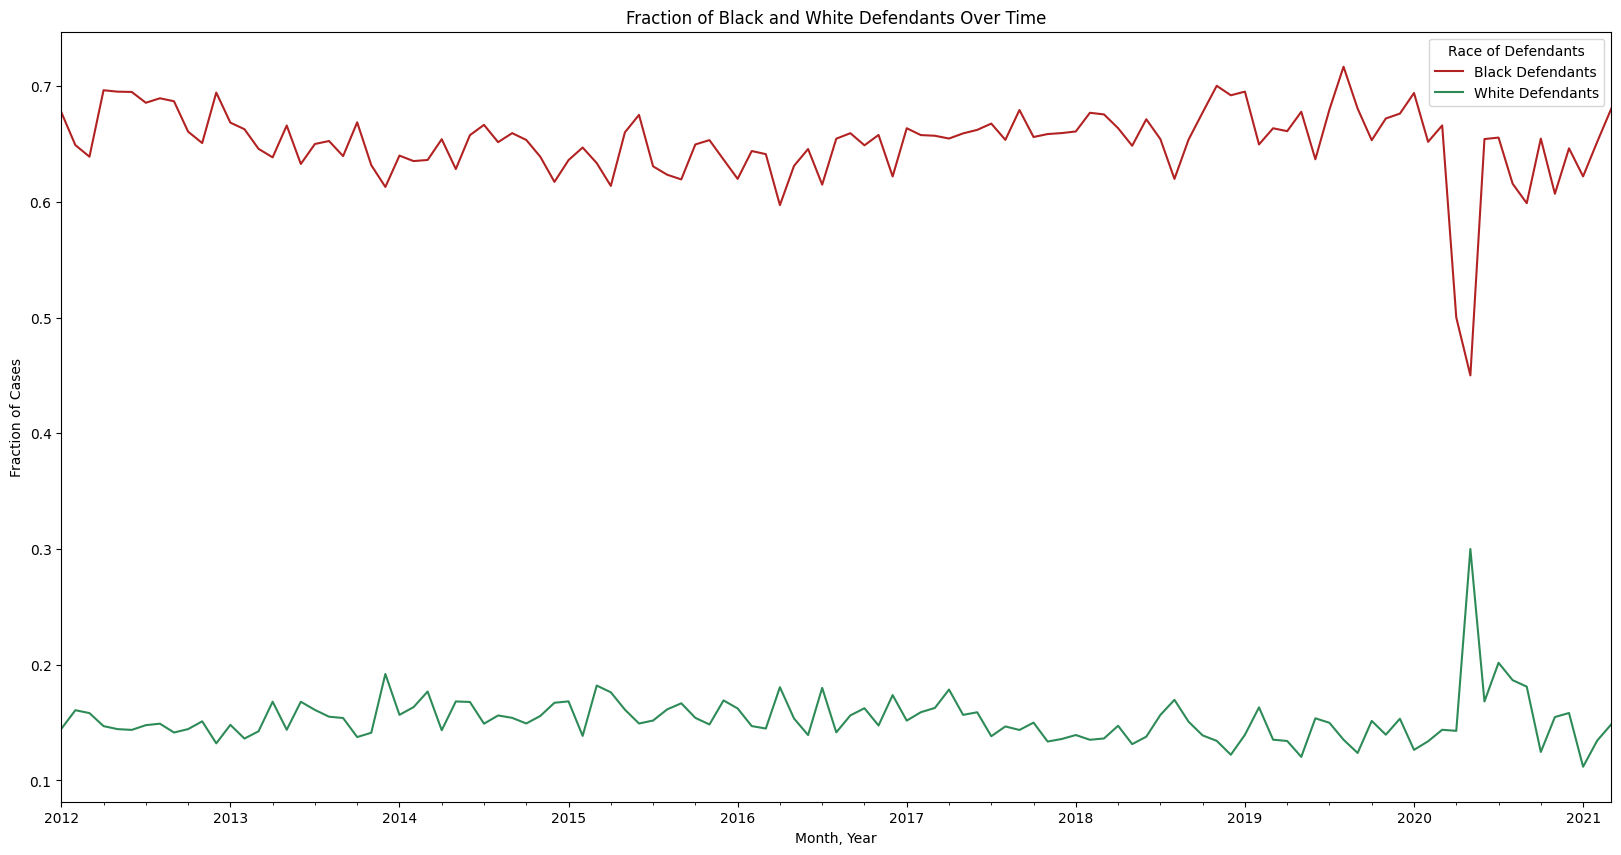

In [375]:
# number of unique cases this month
denominator = cleaned_df.groupby('sentenceym_derived')['CASE_ID'].nunique()

# number of unique black/white defendants
numerator_black_defendants = cleaned_df[cleaned_df['is_black_derived']].groupby('sentenceym_derived')['CASE_PARTICIPANT_ID'].nunique()
numerator_white_defendants = cleaned_df[cleaned_df['is_white_derived']].groupby('sentenceym_derived')['CASE_PARTICIPANT_ID'].nunique()

# fraction
perc_black = numerator_black_defendants / denominator
perc_white = numerator_white_defendants / denominator

# create dataframe
defendants = pd.DataFrame({
    '# of unique cases': denominator,
    '# of black defendants': numerator_black_defendants,
    '# of white defendants': numerator_white_defendants,
    'black defendants percentage': perc_black,
    'white defendants percentage': perc_white
})
defendants.head()

# plot
plt.figure(figsize=(20, 10))
perc_black.plot(label='Black Defendants', color='firebrick')
perc_white.plot(label='White Defendants', color='seagreen')
plt.title('Fraction of Black and White Defendants Over Time')
plt.xlabel('Month, Year')
plt.ylabel('Fraction of Cases')
plt.legend(title='Race of Defendants')
plt.show()

$$P_{\text{black}}
 = \frac{\sum \text{black defendants per month}}{\sum \text{unique cases per month}} $$

$$P_{\text{white}}
 = \frac{\sum \text{white defendants per month}}{\sum \text{unique cases per month}} $$

For the most part, the percentage of Black defendants is much higher than the percentage of white defendants - usually around 65% of the month's defendants are Black, whereas somewhere around 15% of the month's defendants are white. This seems to be relatively consistent except for the outlier in April and May of 2021. In these months, it seems the the proportion of black defendants dipping and the 
proportion of white defendants spiking. This could possibly be due to changes or abnormalities occurring during COVID-19 lockdown in Spring 2020. 



## 2.2: Investigating the first type of disparity: probation versus incaceration (10 points)

One type of disparity beyond who arrives at the sentencing stage is whether the defendant receives probation or incaceration.

According to the codebook, incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections"

Recreate the previous plot but where the y axis represents the difference between the following proportions (can be either Black - White or White - Black but make sure to label), adding a smoothed line:

- Percent of black defendants who are incarcerated out of all black defendants that month/year 
- Percent of white defendants who are incarcerated out of all white defendants that month/year 

In a markdown cell after, write 1-2 sentences on your observations of trends over time. Do gaps seem to be widening or increasing?

<Figure size 2000x1000 with 0 Axes>

<Axes: xlabel='sentenceym_derived'>

<Axes: xlabel='sentenceym_derived'>

<Axes: xlabel='sentenceym_derived'>

Text(0.5, 1.0, 'Difference in Incarceration Rates Between Black and White Defendants')

Text(0, 0.5, 'Proportion Difference')

Text(0.5, 0, 'Month, Year')

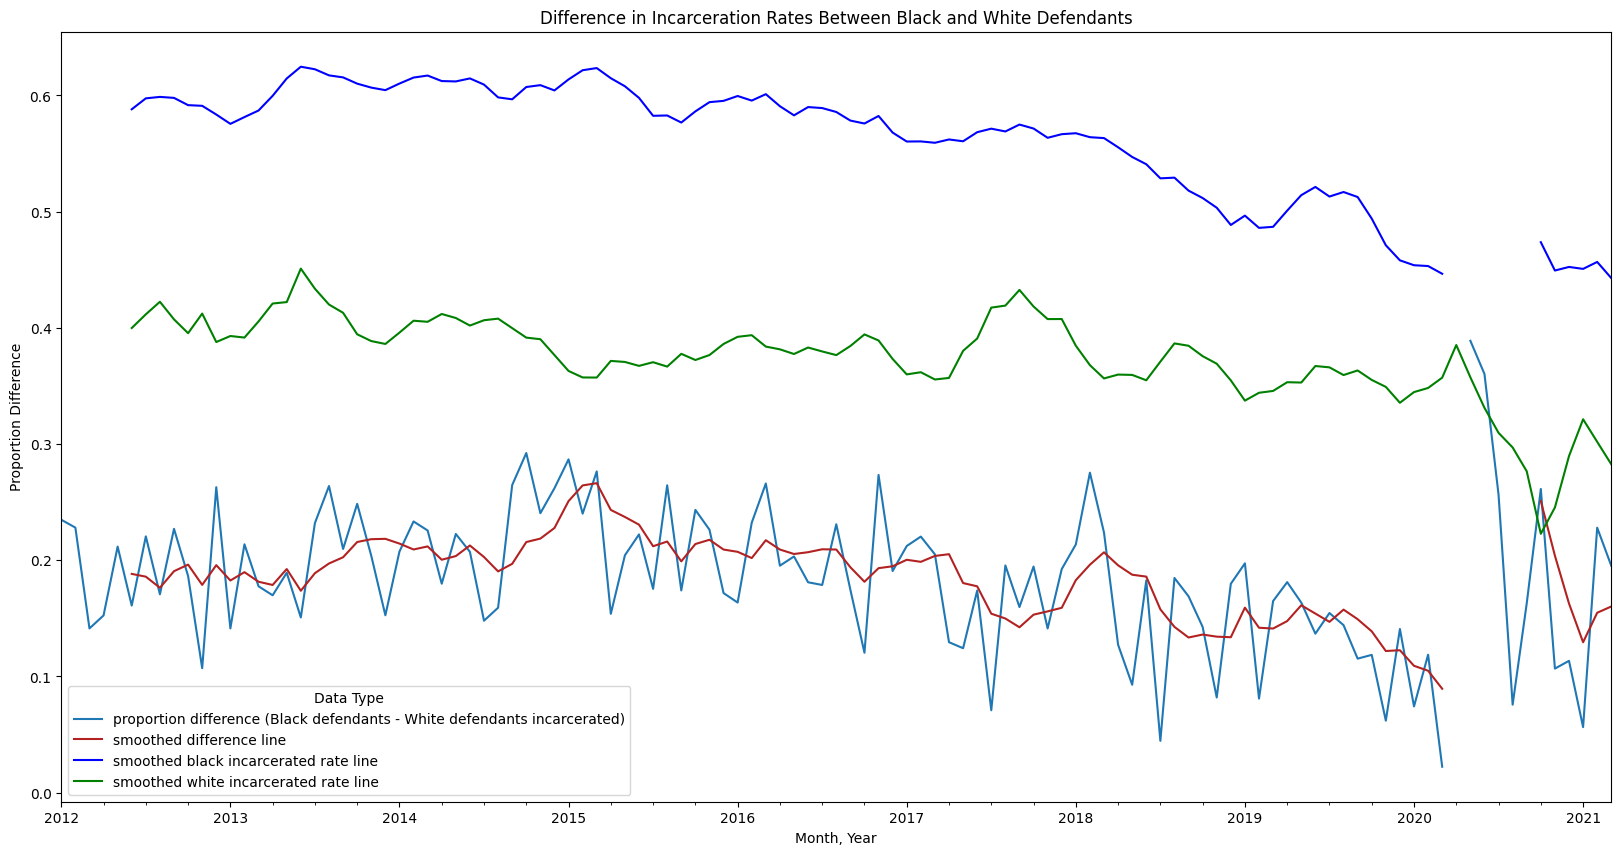

In [370]:
# get only those  who were incarcerated
only_sentenced = cleaned_df[cleaned_df['COMMITMENT_TYPE'] == 'Illinois Department of Corrections']

# black and white defendants who were incarcerated by month
b_i = only_sentenced[only_sentenced['is_black_derived']].groupby('sentenceym_derived')['CASE_PARTICIPANT_ID'].nunique()
w_i = only_sentenced[only_sentenced['is_white_derived']].groupby('sentenceym_derived')['CASE_PARTICIPANT_ID'].nunique()

# previous cell gave us total number of black and white defendants by month - so this gets percent incarcerated by dividing incarcerated defendants by total defendants
black_incarcerated = b_i / numerator_black_defendants
white_incarcerated = w_i / numerator_white_defendants

# calculate the difference
difference = black_incarcerated - white_incarcerated
smooth = difference.rolling(window=6).mean()
smoothed_black_pop = black_incarcerated.rolling(window=6).mean()
smoothed_white_pop = white_incarcerated.rolling(window=6).mean()

# do plotting
plt.figure(figsize=(20, 10))
plot = difference.plot(label='proportion difference (Black defendants - White defendants incarcerated)')
smooth.plot(label='smoothed difference line', color='firebrick')
smoothed_black_pop.plot(label='smoothed black incarcerated rate line', color='blue')
smoothed_white_pop.plot(label='smoothed white incarcerated rate line', color='green')
plot.set_title('Difference in Incarceration Rates Between Black and White Defendants')
plot.set_ylabel('Proportion Difference')
plot.set_xlabel('Month, Year')

plt.legend(title='Data Type')
plt.show()

In general, gaps between white defendants who are incarcerated and black defendants who are incarcerated are slowly decreasing. While there was an especially large gap between the number of Black and white defendants who are incarcerated, the gap was decreased around the spring of 2020. As seen from above, this period was an outlier, and there remains a significant difference between incarceration rates for white defendants and Black defendants, with numbers at 40% for white defendants about about 60% for Black defendants. 

## 2.3: Investigating mechanisms: incaceration rates by charge

Your colleague sees the previous graph and is worried that the gap could be different---either wider or smaller---if you adjust for the fact that prosecutors have discretion in what crimes to charge defendants with. If white defendants are charged with crimes that tend to receive probation rather than incarceration, that could explain some of the gaps.

In the next questions, you'll begin to investigate this.

### 2.3.1: Find the most common offenses (3 points)

First, create a set of 'frequent offenses' that represent (over the entire period) the union of the 10 offenses Black defendant are most likely to be charged with and the 10 offenses white defendants are most likely to be charged with (might be far less than 20 total if there's a lot of overlap in common charges)

Use the `simplified_offense_derived` for this

In [332]:
# subset either only white or only black defendants, group by offense and get the count of them
top10_b_offenses = cleaned_df[cleaned_df['is_black_derived']]['simplified_offense_derived'].value_counts().nlargest(10)
top10_w_offenses = cleaned_df[cleaned_df['is_white_derived']]['simplified_offense_derived'].value_counts().nlargest(10)
frequent_offenses = set()

for offense in top10_b_offenses.index:
    frequent_offenses.add(offense)

for offense in top10_w_offenses.index:
    frequent_offenses.add(offense)

print(frequent_offenses)

{'Residential Burglary', 'Narcotics', 'Battery', 'UUW - Unlawful Use of Weapon', 'Burglary', 'Theft', 'Robbery', 'DUI', 'Other Offense', 'Vehicle-related', 'Retail Theft', 'Driving With Suspended Or Revoked License'}


### 2.3.2: Look at incarceration rates (again just whether incarcerated) by race and offense type for these top offenses (3 points)

Print a wide-format version of the resulting table (so each row is an offense type, one col is black incarceration rate for that offense type; another is the white incarceration rate) and interpret. Which offenses show the largest disparities in judges being less likely to sentence White defendants to incarceration/more likely to offer those defendants probation?


In [372]:
# look only at the top offense
df_offenses_filtered = cleaned_df[cleaned_df['simplified_offense_derived'].isin(frequent_offenses)]
# get dataframe with only incarcerated defendants
only_sentenced = df_offenses_filtered[df_offenses_filtered['COMMITMENT_TYPE'] == 'Illinois Department of Corrections']

# numerators - number of black defendants and white defendants incarcerated by offense
black_incarcerated = only_sentenced[only_sentenced['is_black_derived']].groupby('simplified_offense_derived')['CASE_ID'].nunique()
white_incarcerated = only_sentenced[only_sentenced['is_white_derived']].groupby('simplified_offense_derived')['CASE_ID'].nunique()

# denominators - incarcerated + non incarcerated by offense
black_total = df_offenses_filtered[df_offenses_filtered['is_black_derived']].groupby('simplified_offense_derived')['CASE_ID'].nunique()
white_total = df_offenses_filtered[df_offenses_filtered['is_white_derived']].groupby('simplified_offense_derived')['CASE_ID'].nunique()

# calculate the rate for each by doing incarcerated over total
black_rate = black_incarcerated / black_total
white_rate = white_incarcerated / white_total

# create dfs for white and black incarceration rate
black_incarcerated_df = black_rate.reset_index()
black_incarcerated_df.columns = ['simplified_offense_derived', 'Black Incarceration Rate']

white_incarcerated_df = white_rate.reset_index()
white_incarcerated_df.columns = ['simplified_offense_derived', 'White Incarceration Rate']

# merge the two dfs
incarceration_rates = pd.merge(black_incarcerated_df, white_incarcerated_df, on='simplified_offense_derived')
incarceration_rates.set_index('simplified_offense_derived', inplace=True)
incarceration_rates

Black Incarceration Rate  \
simplified_offense_derived                                            
Battery                                                    0.509032   
Burglary                                                   0.661927   
DUI                                                        0.404997   
Driving With Suspended Or Revoked License                  0.582193   
Narcotics                                                  0.537876   
Other Offense                                              0.340580   
Residential Burglary                                       0.717791   
Retail Theft                                               0.595713   
Robbery                                                    0.650341   
Theft                                                      0.386961   
UUW - Unlawful Use of Weapon                               0.696191   
Vehicle-related                                            0.553750   

                                           White Incarceration Rate  
simplified_offense_derived                                           
Battery                                                    0.275552  
Burglary                                                   0.535763  
DUI                                                        0.341855  
Driving With Suspended Or Revoked License                  0.496552  
Narcotics                                                  0.242535  
Other Offense                                              0.230228  
Residential Burglary                                       0.654114  
Retail Theft                                               0.449582  
Robbery                                                    0.589286  
Theft                                                      0.318721  
UUW - Unlawful Use of Weapon                               0.481973  
Vehicle-related                                            0.585635

There seem to be a few offenses were white defendants are more likely to be offered probation and Black defendants are more likely to be incarcerated, showing a large disparity. These offenses are battery (0.51 for Black defendants, 0.27 for white), narcotics (0.24 for white defendants, 0.53 for Black), retail theft (0.60 for Black defendants, 0.45 for white), and unlawful use of weapon (0.48 for white defendants, 0.70 for Black). 

### 2.3.3: Examine whether this changes pre and post change to charging threshold for retail theft (13 points)

One important question is not only whether there are disparities by offense type but also whether these disparities are changing over time.

The SAO, for instance, announced in December of 2016 that they would no longer default to charging retail thefts of under \$1,000 as felonies. This change might have (1) decreased disparities or (2) increased disparities, depending on the correlation between race/ethnicity and magnitude of goods stolen: [news coverage](https://www.dnainfo.com/chicago/20161215/little-village/kim-foxx-raises-bar-for-retail-theft-felonies/). 

Focusing on `simplified_offense_derived` == "Retail theft." Using a function and/or loop (Dec. 2016 is always excluded as a transition month):

- Compare Black-White disparities before and after the change using a two-month bandwidth (so pre is October and November 2016; post is January and February 2017)

- Compare Black-White disparities before and after the change using a four-month bandwidth (so pre is August- November 2016; post is January - April 2017)

- Compare Black-White disparities using an eight-month bandwidth

- Compare Black-White disparities using a twelve-month bandwidth


------------------ 

- Print a table with the results (any organization is fine as long as it's clear)  

- Create a bar chart where the x axis represents different bandwidths (2, 4, etc); the y axis the size of the Black-White gap in whether the defendant receives incarceration, and for each of the x axis points, you have one shaded bar representing "before" the change, another representing "after" the change (make sure that before is ordered before after and the bandwidths are from smallest to largest)

*Note*: for each of the bandwidths include dates the entire month (e.g., for the first, include not only 02-01-2017 but everything up through 02-28-2017; easiest way is for the subsetting to use the rounded `sentenceym_derived`). Also make sure to only include white or black defendants.


**Extra credit**: because the bandwidths have different sample sizes, a better viz incorporates measures of uncertainty. Add standard errors to the estimates using the formula: $(\dfrac{p(1-p)}{n})^{0.5}$ where $p$ is the gap and $N$ is the number of cases in each bandwidth period 


/var/folders/c_/y_pwd2zx5ps_3xsk7x2275gw0000gp/T/ipykernel_9774/3284956271.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rates = pd.concat([rates, pd.DataFrame({'Bandwidth': [label], 'Pre-Change': [pre_rate], 'Post-Change': [post_rate]})], ignore_index=True)


Bandwidth  Pre-Change  Post-Change
0     two_month    0.087912     0.154949
1    four_month    0.081588     0.081615
2   eight_month    0.132900     0.043450
3  twelve_month    0.161618     0.064705

Text(0.5, 1.0, 'Black-White Disparity in Incarceration Rates for Retail Theft')

Text(0.5, 0, 'Bandwidth (Months)')

[Text(0, 0, 'two_month'),
 Text(1, 0, 'four_month'),
 Text(2, 0, 'eight_month'),
 Text(3, 0, 'twelve_month')]

Text(0, 0.5, 'Black Incarceration Rate - White Incarceration Rate')

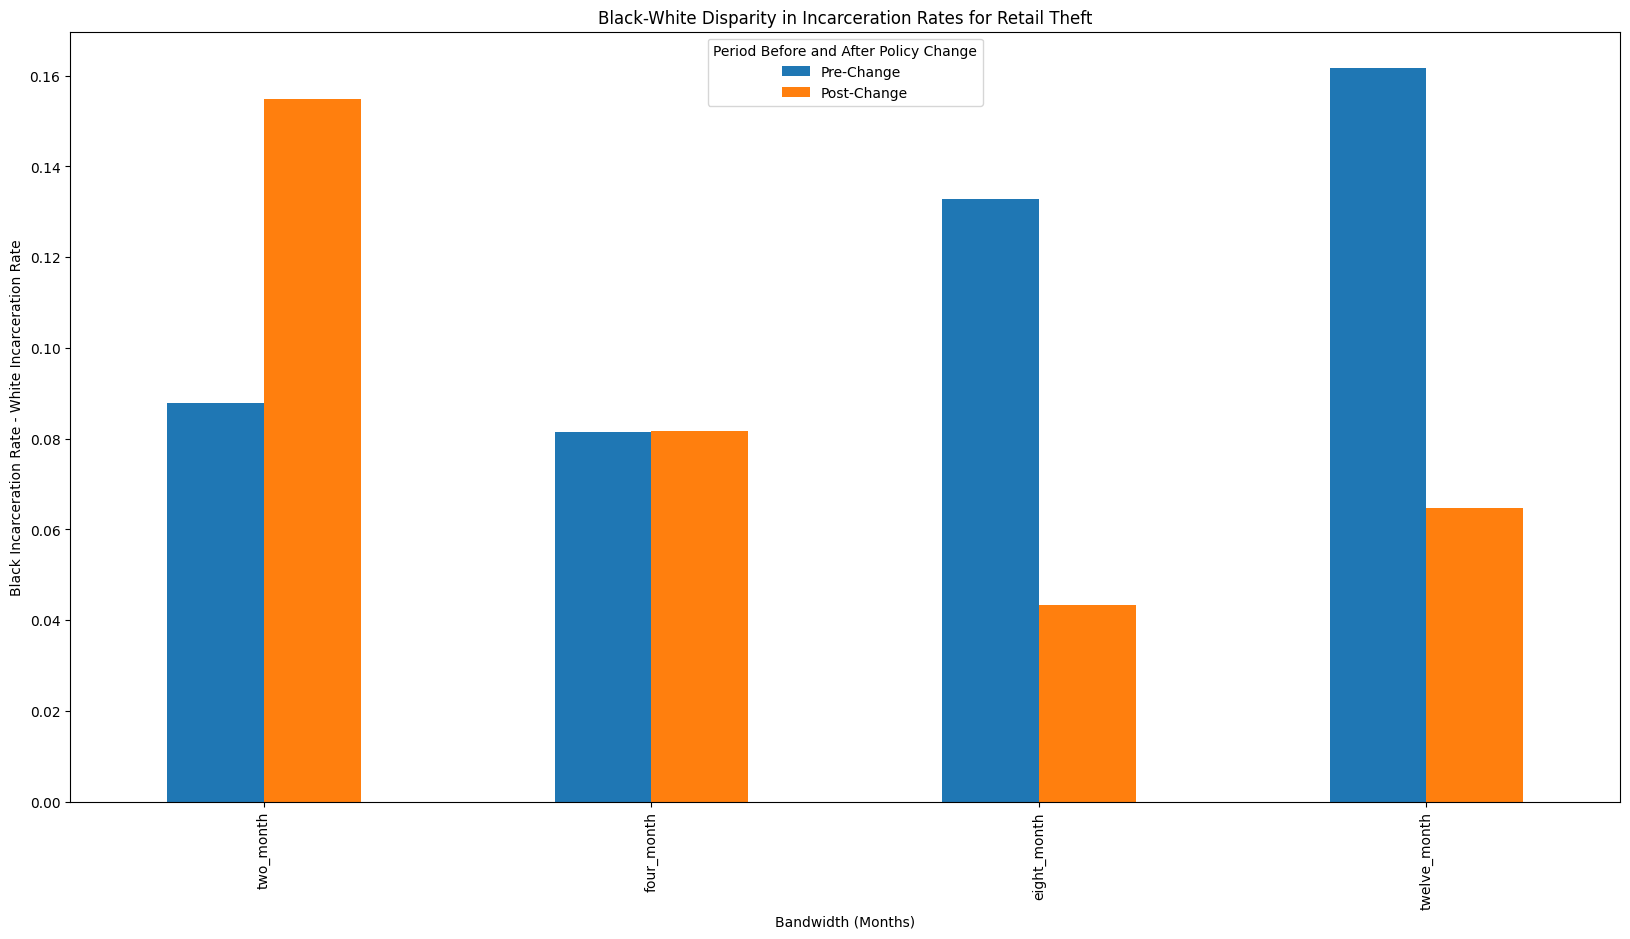

In [373]:
two_month = [['2016-10', '2016-11'], ['2017-01', '2017-02']]
four_month = [['2016-08', '2016-11'], ['2017-01', '2017-04']]
eight_month = [['2016-04', '2016-11'], ['2017-01', '2017-08']]
twelve_month = [['2015-12', '2016-11'], ['2017-01', '2017-12']]
bandwidths = [two_month, four_month, eight_month, twelve_month]
labels = ["two_month", "four_month", "eight_month", "twelve_month"]
df_retail_theft = cleaned_df[(cleaned_df['simplified_offense_derived'] == "Retail Theft")]


def calculate_disparity(data, start_date, end_date):
    filtered_data = data[(data['sentenceym_derived'] >= start_date) & 
                         (data['sentenceym_derived'] <= end_date)]

    # black and white defendants in total charged w retail theft
    black_total = filtered_data[filtered_data['is_black_derived']]['CASE_ID'].nunique()
    white_total = filtered_data[filtered_data['is_white_derived']]['CASE_ID'].nunique()
    
    # black and white defendants in incarcerated charged w retail theft
    incarcerated_retail_theft = filtered_data[filtered_data['COMMITMENT_TYPE'] == 'Illinois Department of Corrections']
    black_incarcerated = incarcerated_retail_theft[incarcerated_retail_theft['is_black_derived']]['CASE_PARTICIPANT_ID'].nunique()
    white_incarcerated = incarcerated_retail_theft[incarcerated_retail_theft['is_white_derived']]['CASE_PARTICIPANT_ID'].nunique()
    
    # rate
    black_rate = black_incarcerated / black_total
    white_rate = white_incarcerated / white_total

    return black_rate - white_rate

rates = pd.DataFrame(columns=['Bandwidth', 'Pre-Change', 'Post-Change'])

# create new table and concatenate for each bandwidth
for bandwidth, label in zip(bandwidths, labels):
    pre_rate = calculate_disparity(df_retail_theft, bandwidth[0][0], bandwidth[0][1])
    post_rate = calculate_disparity(df_retail_theft, bandwidth[1][0], bandwidth[1][1])
    rates = pd.concat([rates, pd.DataFrame({'Bandwidth': [label], 'Pre-Change': [pre_rate], 'Post-Change': [post_rate]})], ignore_index=True)

rates
ax = rates.plot(kind='bar', figsize=(20, 10))
plt.title('Black-White Disparity in Incarceration Rates for Retail Theft')
plt.xlabel('Bandwidth (Months)')
ax.set_xticklabels(labels)
plt.ylabel('Black Incarceration Rate - White Incarceration Rate')
plt.legend(title='Period Before and After Policy Change')
plt.show()

### 2.3.3.1: Interpret the results (2 points)

Write a two-sentence interpretation of the results. What might this show about how people on both sides of the issue---those who argued that the retail theft policy change would narrow disparities; those who argued that the change may widen disparities--could support their claims? 

The post-policy change results show a decrease in racial disparities for longer bandwidths (eight and twelve months) as the difference between white and Black incarceration rates decreases by more than half, but an increase for the immediate two-month period post-change, and almost no change looking at a four-month period. The long-term and short-term view provide evidence for both sides of the argument, as short-term increases supports the idea that the change may widen disparities, while long-term decreases in incarceration rate differences align with arguments that the policy would narrow disparities in retail theft sentencing.